In [1]:
import sys, os
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.io import ascii, fits
from astropy.table import Table, join, hstack, vstack
import pywt
import h5py
sys.path.insert(1, '/home/luiz/IC/Codes/GMCA/gmca4im-master/scripts/')
import gmca4im_lib2 as g4i
from scipy import signal
from sklearn.decomposition import FastICA, PCA
import Extension4BINGO as cs
import pandas as pd
import time

In [2]:
######################################################################################################
####### Tangente hiperbolica como funcão parâmetro G que aproxima a neg-entropy, retorna W
def tanh(x):
    return np.tanh(x), (1/((np.cosh(x))**2)).mean(axis=-1)
######################################################################################################

In [3]:
#PARAMETROS ENTRADA 
######################################################################################################
########FastICA parametros de entrada da função
n = 5
whiten = False
fun = tanh 
max_iter = 1000
tol = 10e-7
######################################################################################################

######################################################################################################
########## Wavelets
wtransform       = "starlet"
maps_wout_mean   = True
apply_mask       = False
add_noise        = False
J     = 3  #number of scales
use_c = True  # if you will use wavelet scale in the analysis
########
# If you to use wtransforms by S2Let code, please, fill in the variables below:
L        = None #If you write "None", it will use L=3*nside
J_min    = 1
B        = 10       
N        = 3  # Number of directions (This is for Directional only)
spin     = 0  # set to 0 for temperature. if non-zero, plotting routines must be changed! (This is for Directional only)
upsample = 0  # 1 means all scales at full resolution L # 0 means multiresolution wavelet transform (This is for Directional only)
######################################################################################################

In [4]:
#Coloca os parâmetros em uma variável só.
######################################################################################################
########
params_CS   = pd.Series({"n":n, "whiten":whiten, "fun":fun, "max_iter":max_iter, "tol":tol})
params_WT   = pd.Series({"wtransform":wtransform, "J":J, "use_c":use_c, "L":L, "Jmin":J_min, "B": B, "N":N, "spin":spin, "upsample":upsample})
######################################################################################################

In [5]:
######## Funções adicionais (realizam a separação ICA, e manipulam as matrizes para o formato apropriado)
######################################################################################################
########
def maps2ICAmaps(X, params_WT, params_CS):
	import gmca4im_lib2 as g4i
	if params_WT.wtransform=="starlet":
		w, c = g4i.wavelet_transform(X,params_WT.J)
	elif params_WT.wtransform=="axisym":
		w, c = coefs_S2LETransform(X,params_WT)
	elif params_WT.wtransform=="directional":
		raise NameError("Not implemented yet: {0}".format(params_WT.wtransform))
	else:
		raise NameError("Not implemented: {0}".format(params_WT.wtransform))
	if params_WT.use_c:
		X_wt = cs.include_scalar_coefs(w,c,params_WT.J)
	else:
		X_wt = w
	#return w,c
	return w2ICAmaps(X_wt, X, params_WT, params_CS)
######################################################################################################

######################################################################################################
########
def w2ICAmaps(X_wt, X, params_WT, params_CS):
    from sklearn.decomposition import FastICA
    print("Starting Component Analysis...")
    time0 = time.time()
    ######################################################################################################
    ######## Algoritmo fastICA para obter a matriz mistura aproximada
    ica = FastICA(n_components = params_CS.n, whiten = params_CS.whiten, fun = params_CS.fun, max_iter = params_CS.max_iter, tol = params_CS.tol)
    S = ica.fit_transform(X_wt.T)  # Reconstruct signals
    A = ica.mixing_  # Get estimated mixing matrix
    ######################################################################################################
    del S, X_wt
    print("Building reconstructed maps...")
    m   = cs.reconstruction_maps(X,A)
    print("Building residuals maps...")
    r   = cs.residual_maps(X,A)
    m_rec_21 = m["21cm"]
    m_rec_fg = m["foregrounds"]
    r_rec_21 = r["21cm"]
    r_rec_fg = r["foregrounds"]
    Am       = A
    
    time0 = time.time()-time0
    print("Finished in: {:.2f} min".format(time0/60))
    
    return {"reconstruction":{"21cm":m_rec_21, "foregrounds":m_rec_fg},"residual":{"21cm":r_rec_21, "foregrounds":r_rec_fg}, "mixmatrix":Am}
######################################################################################################

In [6]:
######## Mapas
NSIDE = 2**8
######################################################################################################
######## Leitura dos arquivos
file_21cm = '/home/luiz/IC/Datas_Maps/exemplos/Cube_21_Smooth_L10.fits' #Arquivo só com 21cm
with fits.open(file_21cm) as hdul1: 
    input_21cm = hdul1[0].data

file_mapas ='/home/luiz/IC/Datas_Maps/exemplos/Cube_5PSM_L10_RS.fits' #Arquivo com tudo, foregrounds+21cm
with fits.open(file_mapas) as hdul2: 
    X = hdul2[0].data
######################################################################################################

In [24]:
########FastICA parametros de entrada da função
#n = 5
#whiten = False
#fun = 'logcosh' 
#max_iter = 200
#tol = 0.0001
######################################################################################################


Wavelet transforming the data . . .
. . completed in 0.92 minutes

Starting Component Analysis...


/home/luiz/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:462: UserWarning: Ignoring n_components with whiten=False.
  warnings.warn('Ignoring n_components with whiten=False.')
/home/luiz/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/home/luiz/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/luiz/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a global

Building reconstructed maps...
Building residuals maps...
Finished in: 0.62 min


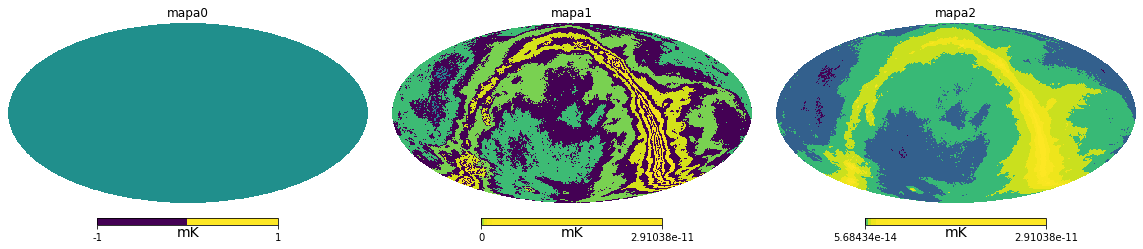

In [9]:
######## fastICA com wavelet starlet, sem mascara, sem white noise
Y = maps2ICAmaps(X[:3], params_WT, params_CS)
######################################################################################################
######## PLOTS
mapas=[Y['reconstruction']['21cm'][0], Y['reconstruction']['21cm'][1], Y['reconstruction']['21cm'][2]] #vetor com os mapas
titulos=['mapa0', 'mapa1', 'mapa2'] #vetor com os nomes
plt.figure(figsize = (16,4))
for i in range(3):
        hp.mollview(mapas[i],sub = (1,3,i+1), norm='hist', title = titulos[i], nest=False, unit='mK' )
######################################################################################################


Wavelet transforming the data . . .
. . completed in 9.74 minutes

Starting Component Analysis...


/home/luiz/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:462: UserWarning: Ignoring n_components with whiten=False.
  warnings.warn('Ignoring n_components with whiten=False.')
/home/luiz/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


Building reconstructed maps...
Building residuals maps...
Finished in: 11.45 min


/home/luiz/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/luiz/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/luiz/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a reg

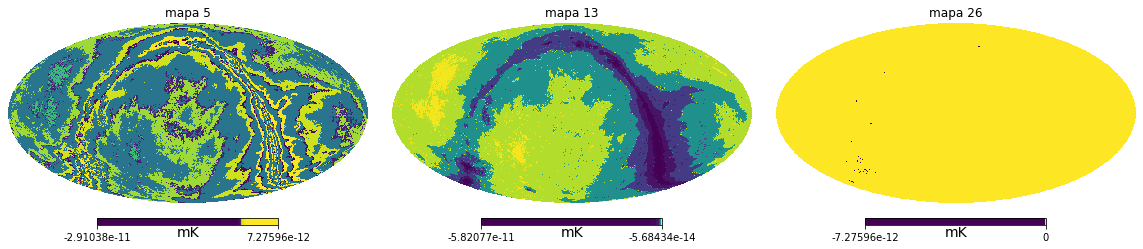

In [10]:
######## fastICA com wavelet starlet, sem mascara, sem white noise
Y = maps2ICAmaps(X, params_WT, params_CS)
######################################################################################################
######## PLOTS
mapas=[Y['reconstruction']['21cm'][5], Y['reconstruction']['21cm'][13], Y['reconstruction']['21cm'][26]] #vetor com os mapas
titulos=['mapa 5', 'mapa 13', 'mapa 26'] #vetor com os nomes
plt.figure(figsize = (16,4))
for i in range(3):
        hp.mollview(mapas[i],sub = (1,3,i+1), norm='hist', title = titulos[i], nest=False, unit='mK' )
######################################################################################################

variância (rec-input):          0.0015913747283309344


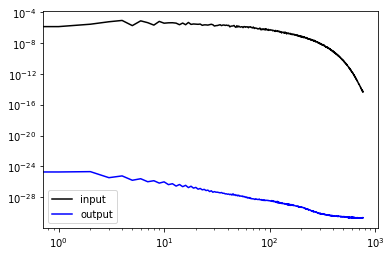

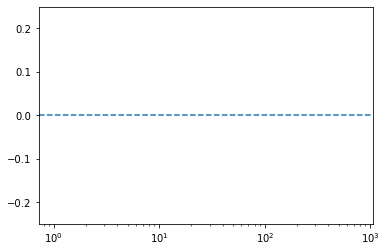

In [15]:
# Conferência dos erros
######################################################################################################
######## Cl's
cl_input = hp.anafast(input_21cm[13])
cl_output = hp.anafast(Y['reconstruction']['21cm'][13])
######################################################################################################

######################################################################################################
######## Comparação do espectro de potência do mapa 21cm com o 21cm reconstruido
plt.figure()
plt.plot(cl_input, color = 'black', label='input')
plt.plot(cl_output, color = 'blue', label='output')
plt.xscale('log')
plt.yscale('log')
plt.legend()
######################################################################################################

######################################################################################################
######## Erro grafico
plt.figure()
plt.plot((cl_input - cl_output)/cl_input)
plt.xscale('log')
plt.ylim(-0.25,0.25)
plt.axhline(y=0, linestyle='dashed')
######################################################################################################

######################################################################################################
######## Erro 
print('variância (rec-input):         ',np.var(Y['reconstruction']['21cm'][13] - input_21cm[13]))
######################################################################################################

In [16]:
# MUDANDO PARAMETROS
######################################################################################################

In [21]:
######## fun = exp e whiten = True
Y = maps2ICAmaps(X, params_WT, params_CS)
######################################################################################################
######## PLOTS
mapas=[Y['reconstruction']['21cm'][5], Y['reconstruction']['21cm'][13], Y['reconstruction']['21cm'][26]] #vetor com os mapas
titulos=['mapa 5', 'mapa 13', 'mapa 26'] #vetor com os nomes
plt.figure(figsize = (16,4))
for i in range(3):
        hp.mollview(mapas[i],sub = (1,3,i+1), norm='hist', title = titulos[i], nest=False, unit='mK' )
######################################################################################################


Wavelet transforming the data . . .
. . completed in 9.25 minutes

Starting Component Analysis...


FloatingPointError: underflow encountered in exp

In [ ]:
# Conferência dos erros
######################################################################################################
######## Cl's
cl_input = hp.anafast(input_21cm[13])
cl_output = hp.anafast(Y['reconstruction']['21cm'][13])
######################################################################################################

######################################################################################################
######## Comparação do espectro de potência do mapa 21cm com o 21cm reconstruido
plt.figure()
plt.plot(cl_input, color = 'black', label='input')
plt.plot(cl_output, color = 'blue', label='output')
plt.xscale('log')
plt.yscale('log')
plt.legend()
######################################################################################################

######################################################################################################
######## Erro grafico
plt.figure()
plt.plot((cl_input - cl_output)/cl_input)
plt.xscale('log')
plt.ylim(-0.25,0.25)
plt.axhline(y=0, linestyle='dashed')
######################################################################################################

######################################################################################################
######## Erro 
print('variância (rec-input):         ',np.var(Y['reconstruction']['21cm'][13] - input_21cm[13]))
######################################################################################################

In [7]:
######## fun = cube
Y = maps2ICAmaps(X, params_WT, params_CS)
######################################################################################################
######## PLOTS
mapas=[Y['reconstruction']['21cm'][5], Y['reconstruction']['21cm'][13], Y['reconstruction']['21cm'][26]] #vetor com os mapas
titulos=['mapa 5', 'mapa 13', 'mapa 26'] #vetor com os nomes
plt.figure(figsize = (16,4))
for i in range(3):
        hp.mollview(mapas[i],sub = (1,3,i+1), norm='hist', title = titulos[i], nest=False, unit='mK' )
######################################################################################################


Wavelet transforming the data . . .
. . completed in 9.65 minutes

Starting Component Analysis...


/home/luiz/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:462: UserWarning: Ignoring n_components with whiten=False.
  warnings.warn('Ignoring n_components with whiten=False.')
/home/luiz/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:60: RuntimeWarning: invalid value encountered in sqrt
  return np.dot(np.dot(u * (1. / np.sqrt(s)), u.T), W)


ValueError: array must not contain infs or NaNs

In [10]:
# Conferência dos erros
######################################################################################################
######## Cl's
cl_input = hp.anafast(input_21cm[13])
cl_output = hp.anafast(Y['reconstruction']['21cm'][13])
######################################################################################################

######################################################################################################
######## Comparação do espectro de potência do mapa 21cm com o 21cm reconstruido
plt.figure()
plt.plot(cl_input, color = 'black', label='input')
plt.plot(cl_output, color = 'blue', label='output')
plt.xscale('log')
plt.yscale('log')
plt.legend()
######################################################################################################

######################################################################################################
######## Erro grafico
plt.figure()
plt.plot((cl_input - cl_output)/cl_input)
plt.xscale('log')
plt.ylim(-0.25,0.25)
plt.axhline(y=0, linestyle='dashed')
######################################################################################################

######################################################################################################
######## Erro 
print('variância (rec-input):         ',np.var(Y['reconstruction']['21cm'][13] - input_21cm[13]))
######################################################################################################

NameError: name 'Y' is not defined


Wavelet transforming the data . . .
. . completed in 9.42 minutes

Starting Component Analysis...


/home/luiz/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:462: UserWarning: Ignoring n_components with whiten=False.
  warnings.warn('Ignoring n_components with whiten=False.')
<ipython-input-2-08a3ee44bf1a>:4: RuntimeWarning: overflow encountered in cosh
  return np.tanh(x), (1/((np.cosh(x))**2)).mean(axis=-1)
<ipython-input-2-08a3ee44bf1a>:4: RuntimeWarning: overflow encountered in square
  return np.tanh(x), (1/((np.cosh(x))**2)).mean(axis=-1)
/home/luiz/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


Building reconstructed maps...
Building residuals maps...
Finished in: 13.81 min


/home/luiz/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/luiz/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/luiz/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a reg

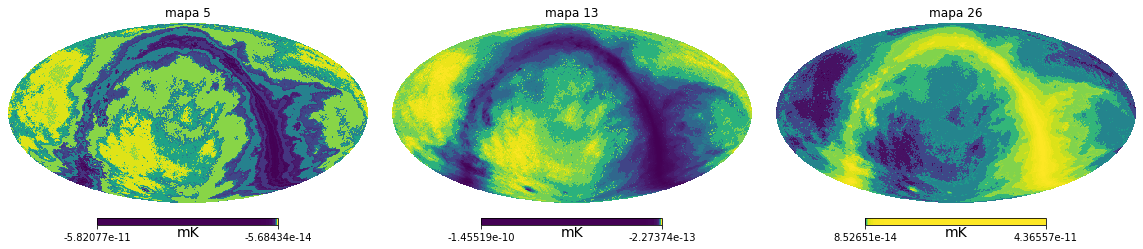

In [11]:
######## fun = tanh
Y = maps2ICAmaps(X, params_WT, params_CS)
######################################################################################################
######## PLOTS
mapas=[Y['reconstruction']['21cm'][5], Y['reconstruction']['21cm'][13], Y['reconstruction']['21cm'][26]] #vetor com os mapas
titulos=['mapa 5', 'mapa 13', 'mapa 26'] #vetor com os nomes
plt.figure(figsize = (16,4))
for i in range(3):
        hp.mollview(mapas[i],sub = (1,3,i+1), norm='hist', title = titulos[i], nest=False, unit='mK' )
######################################################################################################

variância (rec-input):          0.0015913747283317


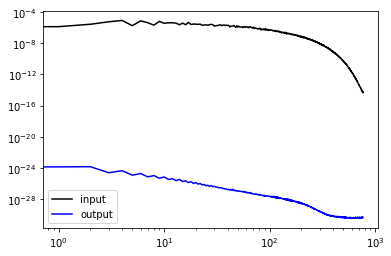

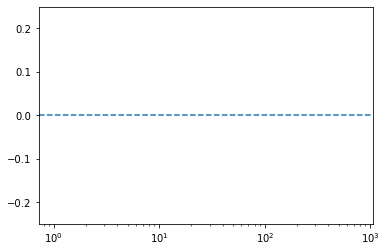

In [12]:
# Conferência dos erros
######################################################################################################
######## Cl's
cl_input = hp.anafast(input_21cm[13])
cl_output = hp.anafast(Y['reconstruction']['21cm'][13])
######################################################################################################

######################################################################################################
######## Comparação do espectro de potência do mapa 21cm com o 21cm reconstruido
plt.figure()
plt.plot(cl_input, color = 'black', label='input')
plt.plot(cl_output, color = 'blue', label='output')
plt.xscale('log')
plt.yscale('log')
plt.legend()
######################################################################################################

######################################################################################################
######## Erro grafico
plt.figure()
plt.plot((cl_input - cl_output)/cl_input)
plt.xscale('log')
plt.ylim(-0.25,0.25)
plt.axhline(y=0, linestyle='dashed')
######################################################################################################

######################################################################################################
######## Erro 
print('variância (rec-input):         ',np.var(Y['reconstruction']['21cm'][13] - input_21cm[13]))
######################################################################################################


Wavelet transforming the data . . .
. . completed in 9.11 minutes

Starting Component Analysis...


/home/luiz/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:462: UserWarning: Ignoring n_components with whiten=False.
  warnings.warn('Ignoring n_components with whiten=False.')
<ipython-input-2-08a3ee44bf1a>:4: RuntimeWarning: overflow encountered in cosh
  return np.tanh(x), (1/((np.cosh(x))**2)).mean(axis=-1)
<ipython-input-2-08a3ee44bf1a>:4: RuntimeWarning: overflow encountered in square
  return np.tanh(x), (1/((np.cosh(x))**2)).mean(axis=-1)
/home/luiz/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


Building reconstructed maps...
Building residuals maps...
Finished in: 69.15 min


/home/luiz/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/luiz/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/luiz/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a reg

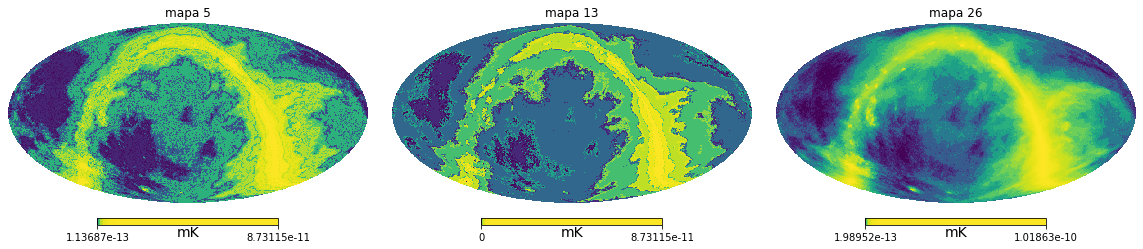

In [7]:
######## max_iter = 1000, tol = 10e-7
Y = maps2ICAmaps(X, params_WT, params_CS)
######################################################################################################
######## PLOTS
mapas=[Y['reconstruction']['21cm'][5], Y['reconstruction']['21cm'][13], Y['reconstruction']['21cm'][26]] #vetor com os mapas
titulos=['mapa 5', 'mapa 13', 'mapa 26'] #vetor com os nomes
plt.figure(figsize = (16,4))
for i in range(3):
        hp.mollview(mapas[i],sub = (1,3,i+1), norm='hist', title = titulos[i], nest=False, unit='mK' )
######################################################################################################

variância (rec-input):          0.0015913747283299742


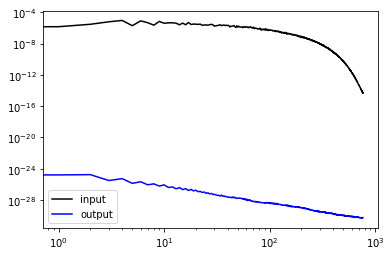

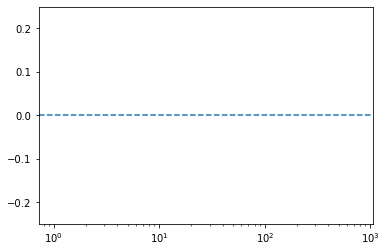

In [8]:
# Conferência dos erros
######################################################################################################
######## Cl's
cl_input = hp.anafast(input_21cm[13])
cl_output = hp.anafast(Y['reconstruction']['21cm'][13])
######################################################################################################

######################################################################################################
######## Comparação do espectro de potência do mapa 21cm com o 21cm reconstruido
plt.figure()
plt.plot(cl_input, color = 'black', label='input')
plt.plot(cl_output, color = 'blue', label='output')
plt.xscale('log')
plt.yscale('log')
plt.legend()
######################################################################################################

######################################################################################################
######## Erro grafico
plt.figure()
plt.plot((cl_input - cl_output)/cl_input)
plt.xscale('log')
plt.ylim(-0.25,0.25)
plt.axhline(y=0, linestyle='dashed')
######################################################################################################

######################################################################################################
######## Erro 
print('variância (rec-input):         ',np.var(Y['reconstruction']['21cm'][13] - input_21cm[13]))
######################################################################################################